# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [5]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from skimage.data import imread
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn.model import log
# Import COCO config
#sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
#import coco

%matplotlib inline 

#print(ROOT_DIR)
# Directory to save logs and trained model
MODEL_DIR = ROOT_DIR

# Local path to trained weights file
MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_asdc_gpu_0026.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
    #utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = ROOT_DIR

In [6]:
class AirbusShipDetectionChallengeGPUConfig(Config):
    """
    Configuration of Airbus Ship Detection Challenge Dataset 
    Overrides values in the base Config class.
    From https://github.com/samlin001/Mask_RCNN/blob/master/mrcnn/config.py
    """
    # https://www.kaggle.com/docs/kernels#technical-specifications
    NAME = 'ASDC_GPU'
    # NUMBER OF GPUs to use.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    NUM_CLASSES = 2  # ship or background
    IMAGE_MIN_DIM = 768
    IMAGE_MAX_DIM = 768
    STEPS_PER_EPOCH = 300
    VALIDATION_STEPS = 100
    SAVE_BEST_ONLY = True
    
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.95

    # Non-maximum suppression threshold for detection
    # Keep it small to merge overlapping ROIs 
    DETECTION_NMS_THRESHOLD = 0.05

    
config = AirbusShipDetectionChallengeGPUConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

In [7]:
class InferenceConfig(AirbusShipDetectionChallengeGPUConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

In [8]:
# Create model object in inference mode.
infer_model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
infer_model.load_weights(MODEL_PATH, by_name=True)

x 3 y 566 h 175 w 50


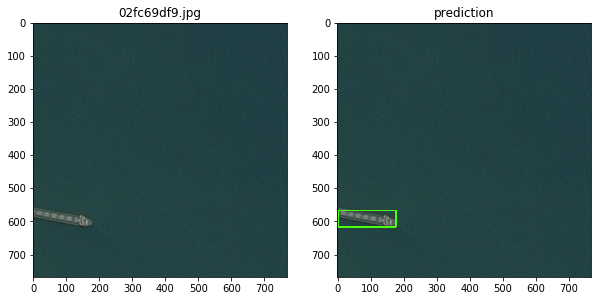

In [9]:
image_id = '02fc69df9.jpg'
raw_image = imread(os.path.join(IMAGE_DIR, image_id))
image = imread(os.path.join(IMAGE_DIR, image_id))

# assume square image 
resize_factor = 1 ## ORIG_SIZE / config.IMAGE_SHAPE[0]

# If grayscale. Convert to RGB for consistency.
if len(image.shape) != 3 or image.shape[2] != 3:
    image = np.stack((image,) * 3, -1) 
#     image, window, scale, padding, crop = utils.resize_image(
#         image,
#         min_dim=config.IMAGE_MIN_DIM,
#         min_scale=config.IMAGE_MIN_SCALE,
#         max_dim=config.IMAGE_MAX_DIM,
#         mode=config.IMAGE_RESIZE_MODE)

results = infer_model.detect([image])
r = results[0]
for bbox in r['rois']: 
#         print(bbox)
    x1 = int(bbox[1] * resize_factor)
    y1 = int(bbox[0] * resize_factor)
    x2 = int(bbox[3] * resize_factor)
    y2 = int(bbox[2]  * resize_factor)
    cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
    width = x2 - x1 
    height = y2 - y1 
    print("x {} y {} h {} w {}".format(x1, y1, width, height))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title(f"{image_id}")
ax1.imshow(raw_image)
ax2.set_title("prediction")
ax2.imshow(image)